In [2]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits

import matplotlib
import matplotlib.colors as mcolors

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

from mmtwfs.wfs import WFSFactory

from minicyclop.io import read_seeing_data

%load_ext autoreload
%autoreload 2
#%matplotlib widget

SMALLER_SIZE = 14
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

In [3]:
# instantiate all of the WFS systems...
wfs_keys = ['f9', 'newf9', 'f5', 'mmirs', 'binospec']
wfs_systems = {}
wfs_names = {}
for w in wfs_keys:
    wfs_systems[w] = WFSFactory(wfs=w)
    wfs_names[w] = wfs_systems[w].name

# give mmirs a default
wfs_systems['mmirs'].default_mode = 'mmirs1'

# map f9 to oldf9
wfs_systems['oldf9'] = wfs_systems['f9']

plt.close('all')

 [astropy.io.fits.verify]


In [5]:
rootdir = Path("./data")
# use find to make this csv list
with open(rootdir / "all_results.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [7]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,301990,1,binospec,301990
f5,118633,1,f5,118633
mmirs,109462,1,mmirs,109462
newf9,5217,1,newf9,5217
oldf9,55777,1,oldf9,55777


In [8]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
#data['seeing'][data['seeing'].apply(isinstance, args=(str,))] = 0.0
fixed = data[[isinstance(x, float) for x in data['seeing']]]
fixed['seeing'] = fixed['seeing'].astype(float)
fixed['airmass'] = fixed['airmass'].astype(float)
fixed = fixed[np.isfinite(fixed['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.2]
fixed = fixed[fixed['seeing'] < 4.]
fixed = fixed[np.isfinite(fixed['airmass'])]
fixed = fixed[fixed['exptime'] >= 5.]

/tmp/ipykernel_1023544/4291593563.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed['seeing'] = fixed['seeing'].astype(float)
/tmp/ipykernel_1023544/4291593563.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed['airmass'] = fixed['airmass'].astype(float)


In [11]:
fixed.drop('time', axis=1, inplace=True)
fixed.to_csv(rootdir / "wfs_seeing.csv")

In [9]:
def correct_tracking(row, tracking_sigma=0.15):
    w = wfs_systems[row['wfs']]
    sigma = stats.gaussian_fwhm_to_sigma * row['fwhm']
    tracking_sigma = tracking_sigma / w.pix_size.value
    if sigma > tracking_sigma:
        sigma = np.sqrt(sigma**2 - tracking_sigma**2)
    else:
        sigma = 0.0
    mode = w.default_mode
    seeing, raw_seeing = w.seeing(mode, sigma, airmass=row['airmass'])
    return seeing

def spot_fwhm(row, tracking_sigma=0.15):
    w = wfs_systems[row['wfs']]
    spot_fwhm = 0.0
    if row['fwhm'] >= w.ref_fwhm:
        spot_fwhm = np.sqrt(row['fwhm']**2 - w.ref_fwhm**2)
    tracking_fwhm = stats.gaussian_sigma_to_fwhm * tracking_sigma / w.pix_size.value
    if spot_fwhm > tracking_fwhm:
        spot_fwhm = np.sqrt(spot_fwhm**2 - tracking_fwhm**2)
    else:
        spot_fwhm = 0.0
    eff_wave = w.eff_wave.to(u.m).value
    wave_corr = .5e-6**-0.2 / eff_wave**-0.2
    spot_fwhm *= wave_corr
    spot_fwhm /= row['airmass']**0.6
    return spot_fwhm * w.pix_size.value

def raw_fwhm(row):
    w = wfs_systems[row['wfs']]
    spot_fwhm = 0.0
    if row['fwhm'] >= w.ref_fwhm:
        spot_fwhm = np.sqrt(row['fwhm']**2 - w.ref_fwhm**2)
    return spot_fwhm * w.pix_size.value


In [10]:
seeing = []
seeing_corr = []
seeing_corr20 = []
seeing_spotfwhm = []
seeing_rawspot = []
for i, row in fixed.iterrows():
    seeing.append(correct_tracking(row, tracking_sigma=0.0).value)
    seeing_corr.append(correct_tracking(row, tracking_sigma=0.15).value)
    seeing_corr20.append(correct_tracking(row, tracking_sigma=0.2).value)
    seeing_spotfwhm.append(spot_fwhm(row, tracking_sigma=0.15))
    seeing_rawspot.append(raw_fwhm(row))

In [11]:
fixed['seeing'] = seeing
fixed['seeing_corr'] = seeing_corr
fixed['seeing_corr20'] = seeing_corr20
fixed['seeing_spotfwhm'] = seeing_spotfwhm
fixed['seeing_rawspot'] = seeing_rawspot
fixed

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms,seeing_corr,seeing_corr20,seeing_spotfwhm,seeing_rawspot
0,2003-04-11T06:30:09,oldf9,20030410_big_run2_0000.fits,20.0,1.0980,91.986000,65.593000,NaN,NaN,NaN,...,266.006339,1.475121,1.560231,10.169277,999.343912,3540.285747,1.391518,1.324105,1.142202,1.160367
1,2003-04-11T06:31:07,oldf9,20030410_big_run2_0001.fits,30.0,1.0960,92.127000,65.798000,NaN,NaN,NaN,...,268.007866,1.634326,1.726733,10.996365,985.418785,3545.406399,1.556343,1.493840,1.254111,1.262676
2,2003-04-11T06:33:55,oldf9,20030410_big_run3_0000.fits,10.0,1.0860,95.818000,67.068000,NaN,NaN,NaN,...,268.011070,1.636542,1.719590,10.961065,1201.032233,3754.173905,1.557902,1.494860,1.256309,1.258322
3,2003-04-11T06:34:38,oldf9,20030410_big_run3_0001.fits,20.0,1.0850,95.949000,67.223000,NaN,NaN,NaN,...,269.001012,1.532514,1.609394,10.414402,1087.814926,3715.734967,1.450117,1.383809,1.183556,1.190756
4,2003-04-11T06:36:36,oldf9,20030410_big_run3_0002.fits,20.0,1.0810,96.310000,67.640000,NaN,NaN,NaN,...,261.997203,1.288457,1.350098,9.112879,923.528642,3420.935969,1.195013,1.118825,1.007683,1.028589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,2024-12-11T12:54:25.687000,binospec,wfs_ff_cal_img_2024.12.11T125425.687.fits,30.0,1.1726,225.583536,58.516830,6.2,6.27,6.6,...,251.003780,1.908648,2.099983,9.584074,371.512903,1424.174477,1.839500,1.784497,1.322019,1.446260
507,2024-12-11T12:54:58.861000,binospec,wfs_ff_cal_img_2024.12.11T125458.861.fits,30.0,1.1737,225.789111,58.433928,6.3,6.22,6.5,...,249.011683,1.941762,2.137619,9.723137,380.171688,1210.196734,1.873491,1.819224,1.342220,1.467829
508,2024-12-11T12:55:31.989000,binospec,wfs_ff_cal_img_2024.12.11T125531.989.fits,30.0,1.1747,225.994107,58.350340,6.7,6.37,6.7,...,250.987446,1.831362,2.017114,9.276605,294.896029,1587.505630,1.760347,1.703766,1.274214,1.398542
509,2024-12-11T12:56:05.154000,binospec,wfs_ff_cal_img_2024.12.11T125605.154.fits,30.0,1.1758,226.199639,58.266108,6.7,6.31,6.7,...,253.001433,2.040474,2.248698,10.131523,363.560522,1489.596284,1.974605,1.922344,1.402071,1.531120


In [12]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms,seeing_corr,seeing_corr20,seeing_spotfwhm,seeing_rawspot
110,2003-04-11T04:37:11,oldf9,20030410_start_0000.fits,30.0,1.0520,170.053000,71.974000,NaN,NaN,NaN,...,223.984180,1.069936,1.102979,7.853245,815.051133,3348.105209,0.960097,0.868504,0.841958,0.869115
111,2003-04-11T04:46:44,oldf9,20030410_start_0001.fits,20.0,1.0600,177.889000,70.693000,NaN,NaN,NaN,...,267.004021,0.939335,0.972756,7.183039,765.374067,3561.569565,0.819375,0.717291,0.737227,0.782722
112,2003-04-11T04:47:06,oldf9,20030410_start_0002.fits,20.0,1.0600,178.162000,70.696000,NaN,NaN,NaN,...,266.980145,0.973240,1.007868,7.364098,775.814801,3529.134502,0.856405,0.757610,0.764888,0.806196
113,2003-04-11T04:47:27,oldf9,20030410_start_0003.fits,20.0,1.0600,178.427000,70.699000,NaN,NaN,NaN,...,266.977349,0.965378,0.999726,7.322134,755.864748,3515.632820,0.847837,0.748306,0.758506,0.800765
114,2003-04-11T04:52:40,oldf9,20030410_start_cor_0000.fits,20.0,1.0600,182.299000,70.698000,NaN,NaN,NaN,...,269.976719,0.763857,0.791035,6.243662,1125.134463,3372.587510,0.623306,0.497262,0.586970,0.658821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,2024-12-11T12:54:25.687000,binospec,wfs_ff_cal_img_2024.12.11T125425.687.fits,30.0,1.1726,225.583536,58.516830,6.2,6.27,6.6,...,251.003780,1.908648,2.099983,9.584074,371.512903,1424.174477,1.839500,1.784497,1.322019,1.446260
507,2024-12-11T12:54:58.861000,binospec,wfs_ff_cal_img_2024.12.11T125458.861.fits,30.0,1.1737,225.789111,58.433928,6.3,6.22,6.5,...,249.011683,1.941762,2.137619,9.723137,380.171688,1210.196734,1.873491,1.819224,1.342220,1.467829
508,2024-12-11T12:55:31.989000,binospec,wfs_ff_cal_img_2024.12.11T125531.989.fits,30.0,1.1747,225.994107,58.350340,6.7,6.37,6.7,...,250.987446,1.831362,2.017114,9.276605,294.896029,1587.505630,1.760347,1.703766,1.274214,1.398542
509,2024-12-11T12:56:05.154000,binospec,wfs_ff_cal_img_2024.12.11T125605.154.fits,30.0,1.1758,226.199639,58.266108,6.7,6.31,6.7,...,253.001433,2.040474,2.248698,10.131523,363.560522,1489.596284,1.974605,1.922344,1.402071,1.531120


In [13]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

In [14]:
fixed['seeing'].median(), fixed['seeing_corr'].median()

(1.112064359402309, 1.019407357339256)

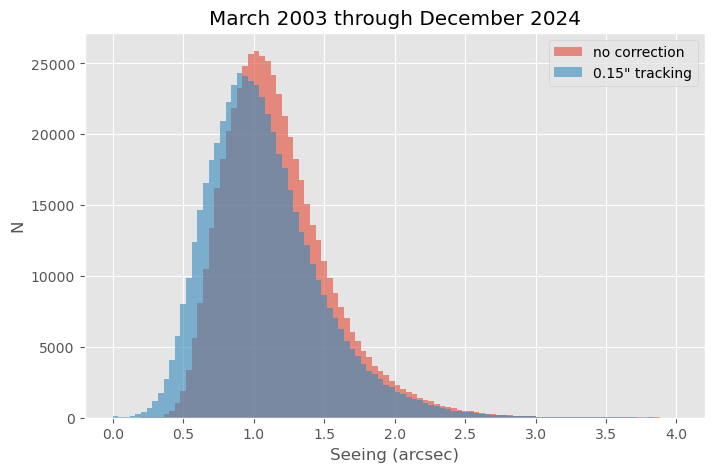

In [16]:
# make raw histogram of the zenith-corrected seeing column
#fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    plt.hist(fixed['seeing'], bins=100, range=(0.0, 4.), alpha=0.6, label="no correction")
    plt.hist(fixed['seeing_corr'], bins=100, range=(0.0, 4.), alpha=0.6, label="0.15\" tracking")
    #plt.hist(fixed['seeing_corr20'], bins=100, range=(0.0, 4.), alpha=0.6, label="0.2\" tracking")
    #plt.hist(fixed['seeing_rawspot'], bins=100, range=(0.0, 4.), alpha=0.6, label="Spot FWHM")
    #plt.hist(fixed['seeing_spotfwhm'], bins=100, range=(0.0, 4.), alpha=0.6, label="Spot FWHM, 0.15\" tracking")
    plt.legend()
    plt.title("March 2003 through December 2024")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

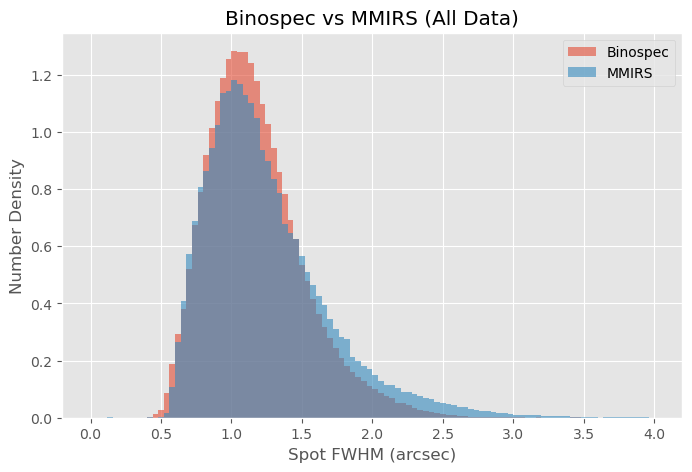

In [18]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    plt.hist(fixed['seeing'][fixed['wfs'] == 'binospec'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label="Binospec")
    plt.hist(fixed['seeing'][fixed['wfs'] == 'mmirs'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label="MMIRS")
    plt.legend()
    plt.title("Binospec vs MMIRS (All Data)")
    plt.xlabel("Spot FWHM (arcsec)")
    plt.ylabel("Number Density")
plt.savefig("bino_vs_mmirs.pdf")
plt.show()

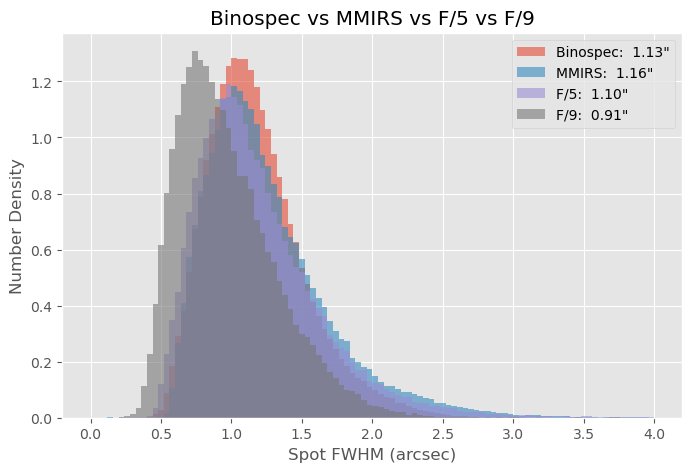

In [19]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['seeing'][fixed['wfs'] == 'binospec'])
    medm = np.median(fixed['seeing'][fixed['wfs'] == 'mmirs'])
    med5 = np.median(fixed['seeing'][fixed['wfs'] == 'f5'])
    med9 = np.median(fixed['seeing'][(fixed['wfs'] == 'oldf9') | (fixed['wfs'] == 'newf9')])
    plt.hist(fixed['seeing'][fixed['wfs'] == 'binospec'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Binospec: {medb: .2f}\"")
    plt.hist(fixed['seeing'][fixed['wfs'] == 'mmirs'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
    plt.hist(fixed['seeing'][fixed['wfs'] == 'f5'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"F/5: {med5: .2f}\"")
    plt.hist(fixed['seeing'][(fixed['wfs'] == 'oldf9') | (fixed['wfs'] == 'newf9')], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"F/9: {med9: .2f}\"")
    plt.legend()
    plt.title("Binospec vs MMIRS vs F/5 vs F/9")
    plt.xlabel("Spot FWHM (arcsec)")
    plt.ylabel("Number Density")
plt.savefig("bino_vs_mmirs_vs_f5_vs_f9.pdf")
plt.show()

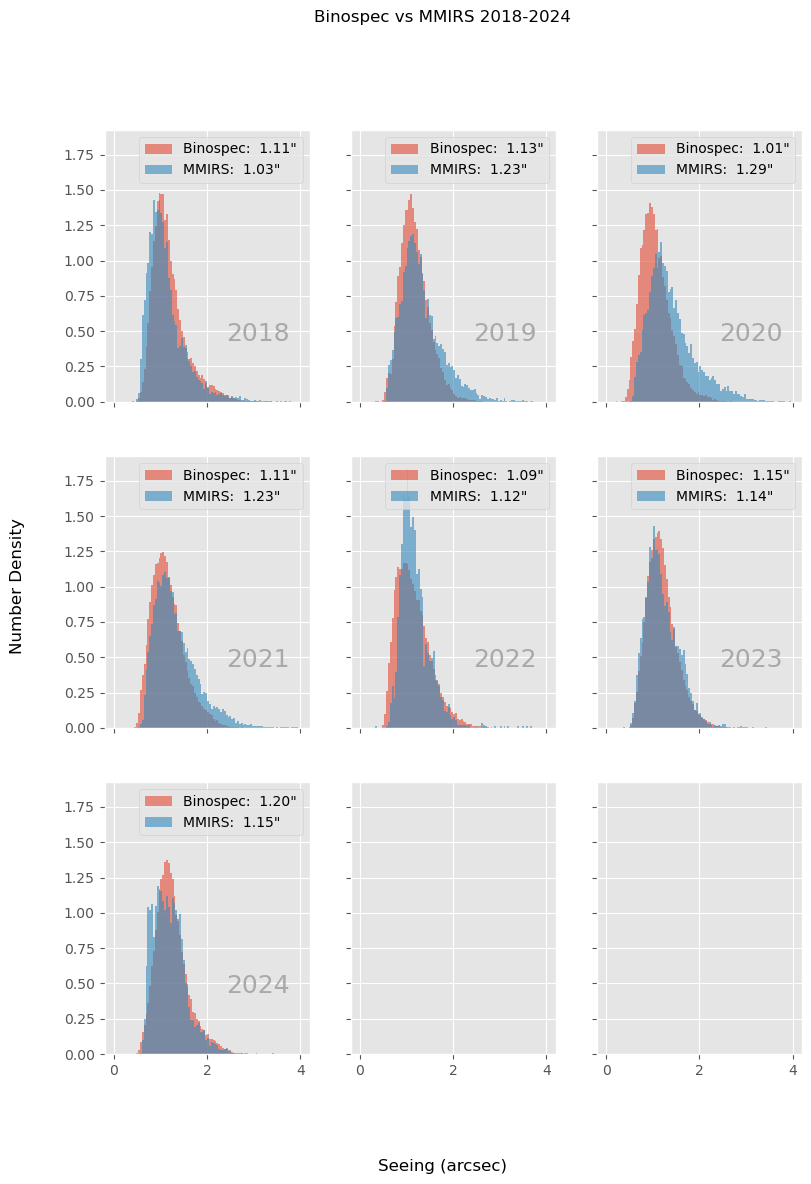

In [22]:
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9, 12))
    fig.suptitle("Binospec vs MMIRS 2018-2024")
    fig.supylabel("Number Density")
    fig.supxlabel("Seeing (arcsec)")
    years = [str(y) for y in range(2018, 2025)]
    for ((i, year), ax) in zip(enumerate(years), axs.flat):
        year_df = fixed.loc[year]
        medb = np.median(year_df['seeing'][year_df['wfs'] == 'binospec'])
        medm = np.median(year_df['seeing'][year_df['wfs'] == 'mmirs'])
        ax.hist(year_df['seeing'][year_df['wfs'] == 'binospec'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Binospec: {medb: .2f}\"")
        ax.hist(year_df['seeing'][year_df['wfs'] == 'mmirs'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
        ax.annotate(
            year,
            (0.75, 0.25),
            xycoords='axes fraction',
            ha='center',
            va='center',
            fontsize=18,
            color='darkgrey'
        )
        ax.legend()
plt.savefig("binospec_vs_mmirs_yearly.pdf")
plt.show()

In [23]:
def wave_correct(seeing, obs_wave):
    refwave = 0.5
    wave_corr = refwave ** -0.2 / obs_wave ** -0.2
    return seeing * wave_corr

In [24]:
fixed['seeing_spot_airmass'] = fixed['seeing_rawspot'] / fixed['airmass']**0.6

In [25]:
fixed['seeing_spot_airmass'][fixed['wfs'] == 'binospec'].median(), fixed['seeing_spot_airmass'][fixed['wfs'] == 'mmirs'].median()

(0.8412898840968925, 0.8931103445676054)

In [ ]:
wave_correct(1.11, 0.55)

1.131361812905517

In [27]:
fixed['seeing_spot_airmass'][fixed['wfs'] == 'newf9'].median(), fixed['seeing_spot_airmass'][fixed['wfs'] == 'mmirs'].median()

(0.8887461487199697, 0.8931103445676054)

In [28]:
fixed['seeing'][fixed['wfs'] == 'binospec'].median(), fixed['seeing'][fixed['wfs'] == 'mmirs'].median()

(1.1260760763638857, 1.1572125852977648)

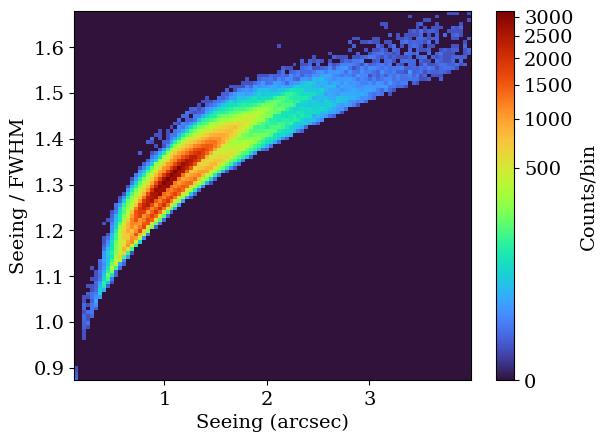

In [29]:
with plt.style.context('default'):
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.hist2d(fixed['seeing'], fixed['seeing'] / fixed['seeing_spot_airmass'], bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Seeing / FWHM")
    cb = plt.colorbar()
    cb.set_label("Counts/bin")
    #plt.savefig("seeing_tempdiff.png")
    #plt.savefig("seeing_tempdiff.pdf")
    plt.show()

In [30]:
# fit a log-normal distribution to the seeing data
seeing = np.array(fixed['seeing'], dtype=float)
seeing = seeing[np.isfinite(seeing)]
sigma, loc, exp_mu = lognorm.fit(seeing)
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.median(seeing)
fit_median = exp_mu + loc

0.33192201921166437 0.04066148274271246 1.0721536530192897


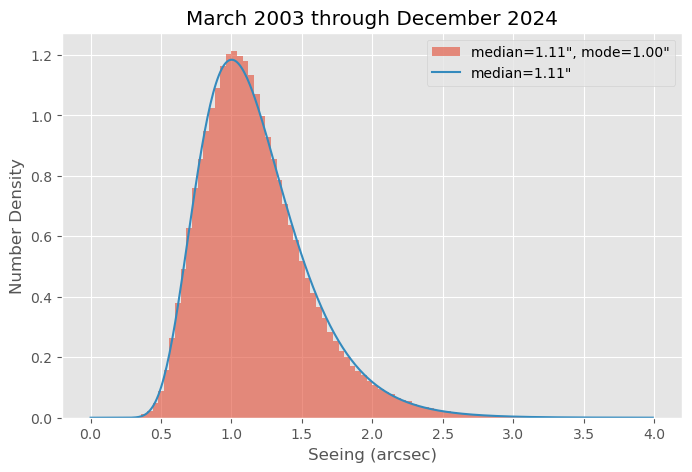

In [31]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("March 2003 through December 2024")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("all_hist.png")
    plt.savefig("all_hist.pdf")
plt.show()

In [32]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.nanmedian(first_half['seeing'])
med_2nd = np.nanmedian(second_half['seeing'])

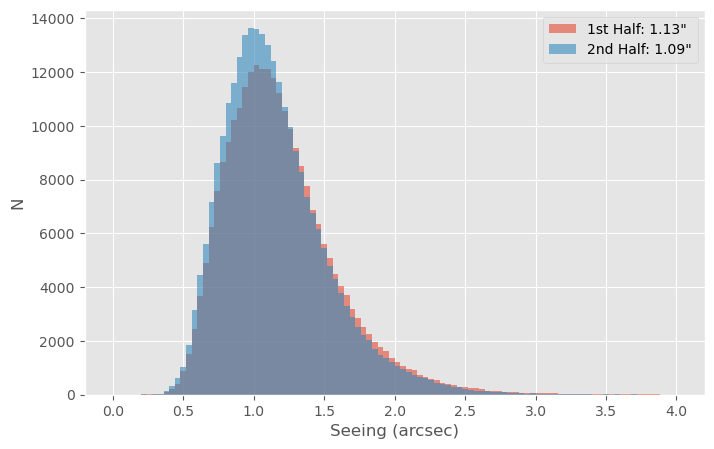

In [33]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("all_1st2nd.png")
plt.savefig("all_1st2nd.pdf")
plt.show()

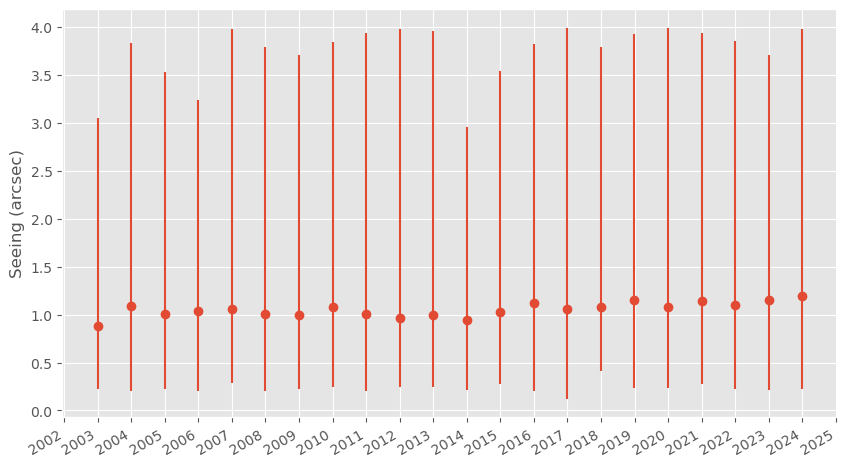

In [34]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots(figsize=(10, 6))
monthly = pd.DataFrame()
monthly['seeing'] = fixed.seeing.resample('Y', label='left').median()
monthly['max'] = fixed.seeing.resample('Y', label='left').max()
monthly['min'] = fixed.seeing.resample('Y', label='left').min()
lowb = monthly['seeing'] - monthly['min']
upb = monthly['max'] - monthly['seeing']
plt.errorbar(monthly.index, monthly['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("all_nightly.png")
plt.savefig("all_nightly.pdf")
plt.show()

In [35]:
year_list = [str(y) for y in range(2003, 2025)]
data = [np.array(fixed.loc[month]['seeing']) for month in year_list]
clean_data = {}
for d, arr in zip(year_list, data):
    if len(arr) > 0:
        clean_data[d] = arr[np.isfinite(arr)]
year_labels = [datetime.strptime(d, "%Y").date() for d in clean_data.keys()]
sizes = [len(clean_data[y]) for y in clean_data]
year_list

['2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023',
 '2024']

In [36]:
first_meds = []
sec_meds = []
for y in clean_data:
    year = fixed.loc[y]
    first_half = year.between_time(start_time='00:00', end_time='07:00')
    second_half = year.between_time(start_time='07:00', end_time='14:00')
    med_1st = np.nanmedian(first_half['seeing'])
    med_2nd = np.nanmedian(second_half['seeing'])
    first_meds.append(med_1st)
    sec_meds.append(med_2nd)
    print(f"{y}: {med_1st:.2f} {med_2nd:.2f}")

2003: 0.92 0.85
2004: 1.08 1.10
2005: 1.10 0.94
2006: 1.02 1.07
2007: 1.10 1.01
2008: 1.01 1.00
2009: 0.98 1.02
2010: 1.10 1.04
2011: 1.03 0.98
2012: 0.97 0.95
2013: 1.07 0.88
2014: 0.99 0.90
2015: 1.05 1.02
2016: 1.17 1.10
2017: 1.10 1.03
2018: 1.08 1.08
2019: 1.17 1.15
2020: 1.10 1.06
2021: 1.16 1.12
2022: 1.10 1.09
2023: 1.20 1.12
2024: 1.23 1.17


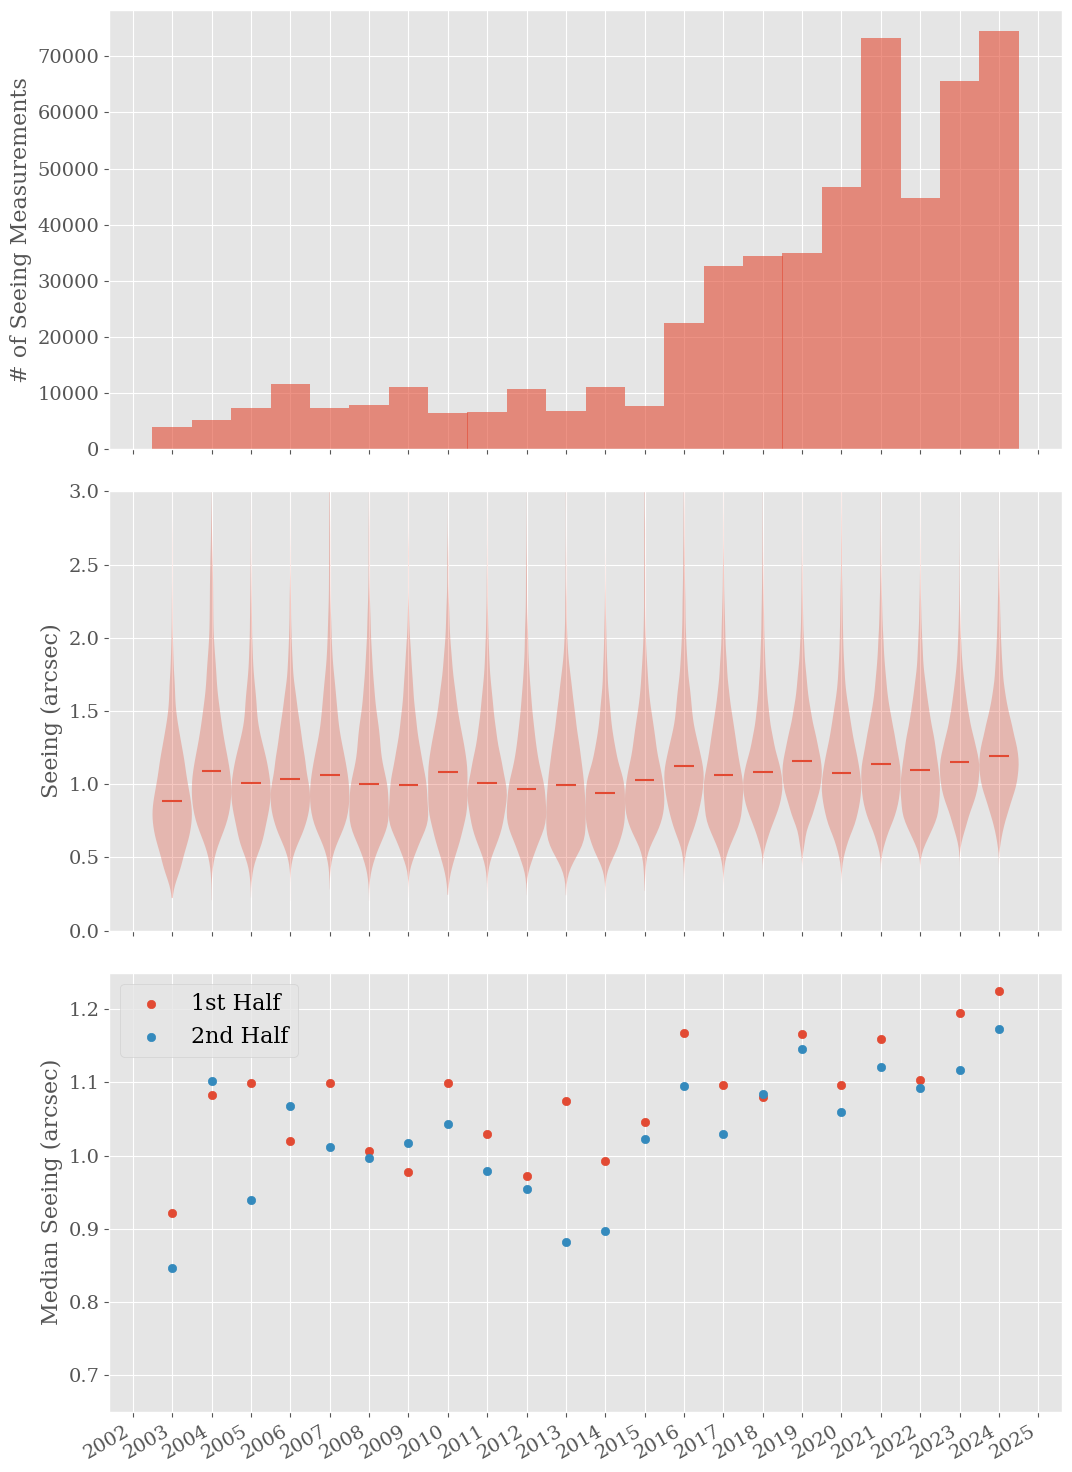

In [37]:
with plt.style.context('ggplot'):
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALLER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALLER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
    fig, ax = plt.subplots(3, figsize=(11,15), sharex=True)
    ax[0].bar(mdates.date2num(year_labels), sizes, width=366, alpha=0.6)
    ax[0].set_ylabel("# of Seeing Measurements")
    ax[1].violinplot(clean_data.values(), mdates.date2num(year_labels), points=100, widths=365,
                showextrema=False, showmedians=True, bw_method='silverman')


    ax[1].set_ylim(0.0, 3.0)
    ax[1].set_ylabel("Seeing (arcsec)")
    ax[2].scatter(mdates.date2num(year_labels), first_meds, label="1st Half")
    ax[2].scatter(mdates.date2num(year_labels), sec_meds, label="2nd Half")
    ax[2].legend(frameon=True, fancybox=True)
    ax[2].set_ylim(0.65, 1.25)
    ax[2].set_ylabel("Median Seeing (arcsec)")
    ax[2].xaxis.set_major_locator(mdates.YearLocator())
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.savefig("all_violin.png")
    plt.savefig("all_violin.pdf")
    plt.show()

In [38]:
[len(clean_data[y]) for y in clean_data]

[3961,
 5155,
 7296,
 11572,
 7294,
 7820,
 11126,
 6486,
 6666,
 10708,
 6905,
 11184,
 7734,
 22556,
 32579,
 34406,
 34942,
 46763,
 73264,
 44699,
 65599,
 74523]

In [39]:
diff = fixed['osst'] - fixed['outt']
trim_seeing = fixed['seeing'][np.abs(diff) < 100]
diff = diff[np.abs(diff) < 100]

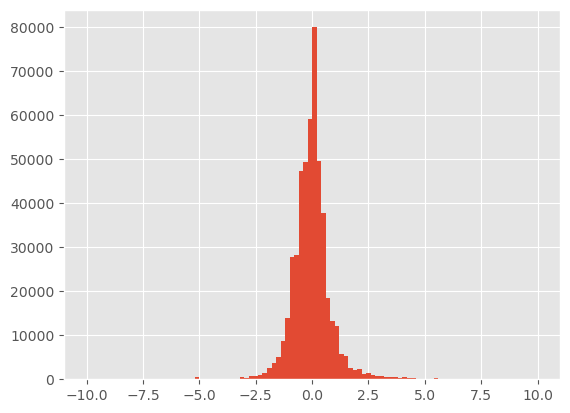

In [40]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    ax.hist(diff, bins=100, range=(-10, 10))
plt.show()

In [41]:
temps = list(range(-3,6))
t_meds = []
for t in temps:
    seeing_slice = trim_seeing[(diff >= t-0.5) & (diff <= t+0.5)]
    t_meds.append(np.median(seeing_slice))
t_meds, temps

([np.float64(1.1940828557790957),
  np.float64(1.1108393024141519),
  np.float64(1.0746208096655328),
  np.float64(1.111505820220422),
  np.float64(1.192058361794004),
  np.float64(1.2496787885416967),
  np.float64(1.3266235242391733),
  np.float64(1.3556424505718843),
  np.float64(1.4580003388182576)],
 [-3, -2, -1, 0, 1, 2, 3, 4, 5])

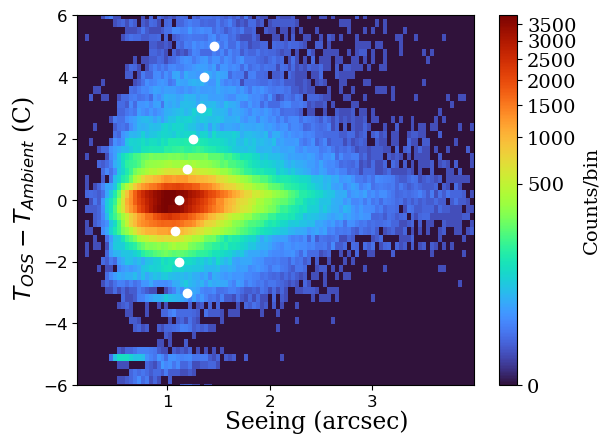

In [42]:
with plt.style.context('default'):
    fig, ax = plt.subplots()
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    h = ax.hist2d(trim_seeing, diff, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("$T_{OSS} - T_{Ambient}$ (C)")
    cb = fig.colorbar(h[-1])
    cb.set_label("Counts/bin")
    ax.set_ybound(-6, 6)
    ax.scatter(t_meds, temps, color='w')
    ax.tick_params(axis='both', labelsize=12)

plt.savefig("seeing_tempdiff.png")
plt.savefig("seeing_tempdiff.pdf")
plt.show()

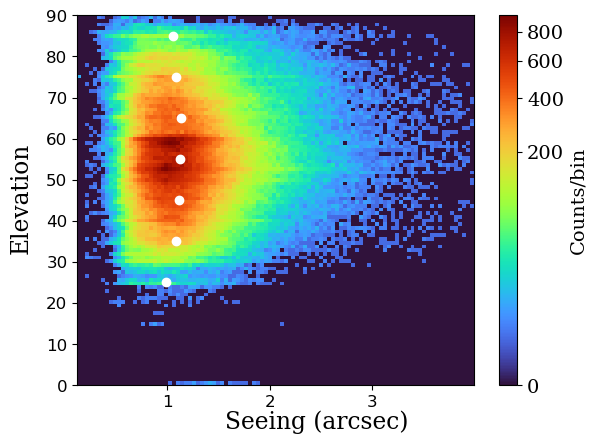

In [43]:
trimmed = fixed[np.isfinite(fixed['seeing'].astype(float)) & np.isfinite(fixed['el'].astype(float))]
trim_el = trimmed['el'].astype(float)
el_seeing = trimmed['seeing'].astype(float)
els = [25, 35, 45, 55, 65, 75, 85]
e_meds = []
for el in els:
    seeing_slice = el_seeing[(trim_el >= el-5) & (trim_el <= el+5)]
    e_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    fig, ax = plt.subplots()
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    h = ax.hist2d(el_seeing, trim_el, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("Elevation")
    cb = fig.colorbar(h[-1])
    cb.set_label("Counts/bin")
    plt.scatter(e_meds, els, color='w')
    ax.tick_params(axis='both', labelsize=12)

plt.savefig("seeing_elevation.png")
plt.savefig("seeing_elevation.pdf")
plt.show()

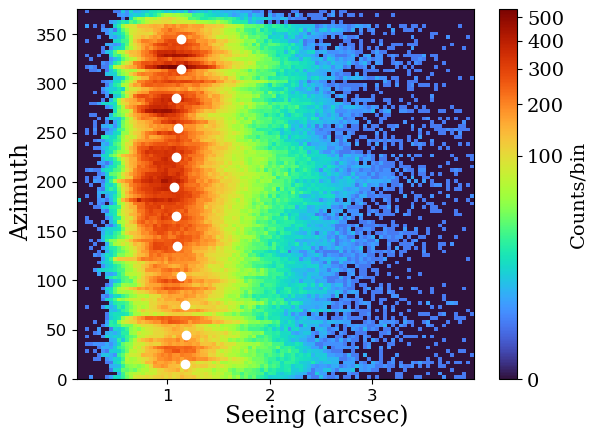

In [44]:
trimmed = fixed[np.isfinite(fixed['seeing'].astype(float)) & np.isfinite(fixed['az'].astype(float))]
trim_az = trimmed['az'].astype(float)
trim_az[trim_az < 0] += 360.
az_seeing = trimmed['seeing'].astype(float)
azs = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]
a_meds = []
for az in azs:
    seeing_slice = az_seeing[(trim_az >= az-15) & (trim_az <= az+15)]
    a_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    fig, ax = plt.subplots()
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    h = ax.hist2d(az_seeing, trim_az, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("Azimuth")
    cb = fig.colorbar(h[-1])
    cb.set_label("Counts/bin")
    ax.scatter(a_meds, azs, color='w')
    ax.tick_params(axis='both', labelsize=12)

plt.savefig("seeing_azimuth.png")
plt.savefig("seeing_azimuth.pdf")
plt.show()

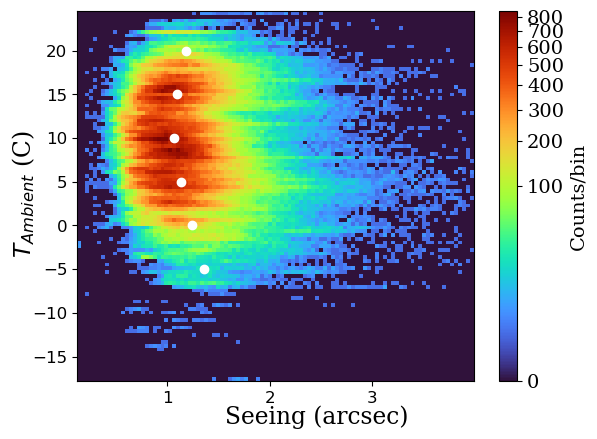

In [45]:
trimmed = fixed[np.isfinite(fixed['seeing'].astype(float)) & np.isfinite(fixed['outt'].astype(float))]
trim_outt = trimmed['outt'].astype(float)
outt_seeing = trimmed['seeing'].astype(float)
temps = list(range(-5, 25, 5))
temps_meds = []
for t in temps:
    seeing_slice = outt_seeing[(trim_outt >= t-2.5) & (trim_outt <= t+2.5)]
    temps_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    fig, ax = plt.subplots()
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    h = ax.hist2d(outt_seeing, trim_outt, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("$T_{Ambient}$ (C)")
    cb = fig.colorbar(h[-1])
    cb.set_label("Counts/bin")
    ax.scatter(temps_meds, temps, color='w')
    ax.tick_params(axis='both', labelsize=12)

plt.savefig("seeing_ambient.pdf")
plt.savefig("seeing_ambient.png")
plt.show()

In [52]:
fixed.to_csv("all_seeing.csv")

In [59]:
plt.close('all')

In [46]:
from minicyclop.io import read_seeing_data
cyc = read_seeing_data(Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt")
cyc.drop('UT', axis=1, inplace=True)
cyc

,flux,seeing,r0,isot,epoch_ms
ut,,,,,
2022-06-08 03:32:32,2733.7,0.84,135.8,2022-06-08T03:32:32.968,1654659152968
2022-06-08 03:33:27,2755.7,0.84,134.4,2022-06-08T03:33:27.409,1654659207408
2022-06-08 03:34:23,2801.6,2.38,47.7,2022-06-08T03:34:23.655,1654659263655
2022-06-08 03:35:16,2853.2,1.01,112.3,2022-06-08T03:35:16.325,1654659316324
2022-06-08 03:36:00,2739.0,1.03,110.7,2022-06-08T03:36:00.691,1654659360691
...,...,...,...,...,...
2024-12-16 13:51:10,1536.9,1.12,101.3,2024-12-16T13:51:10.045,1734357070045
2024-12-16 13:51:59,1571.7,1.07,106.5,2024-12-16T13:51:59.518,1734357119518
2024-12-16 13:52:50,1588.1,1.30,87.0,2024-12-16T13:52:50.140,1734357170139


In [16]:
cyc.to_csv("cyclop_seeing.csv")

In [47]:
fixed_overlap = fixed[fixed.index >= "2022-06-07"]

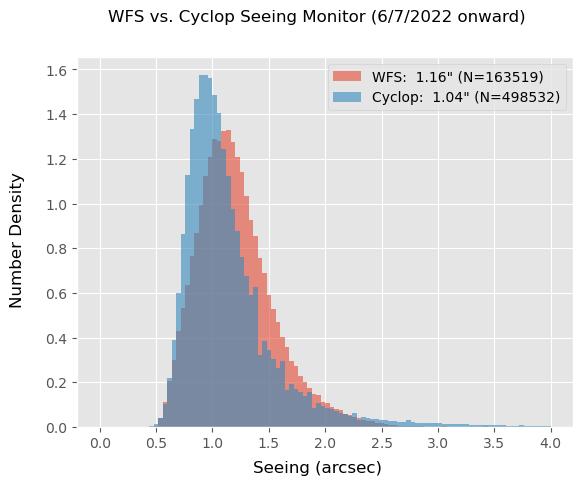

In [49]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    med_wfs = np.median(fixed_overlap['seeing'])
    med_cyc = np.median(cyc['seeing'])
    w = ax.hist(fixed_overlap['seeing'], density=True, bins=100, range=(0.0, 4.0), label=f"WFS: {med_wfs: .2f}\" (N={len(fixed_overlap)})", alpha=0.6)
    c = ax.hist(cyc['seeing'], density=True, bins=100, range=(0.0, 4.0), label=f"Cyclop: {med_cyc: .2f}\" (N={len(cyc)})", alpha=0.6)
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("Number Density")
    fig.suptitle("WFS vs. Cyclop Seeing Monitor (6/7/2022 onward)")
    ax.legend()
plt.savefig("wfs_cyclop.pdf")
plt.savefig("wfs_cyclop.png")
plt.show()

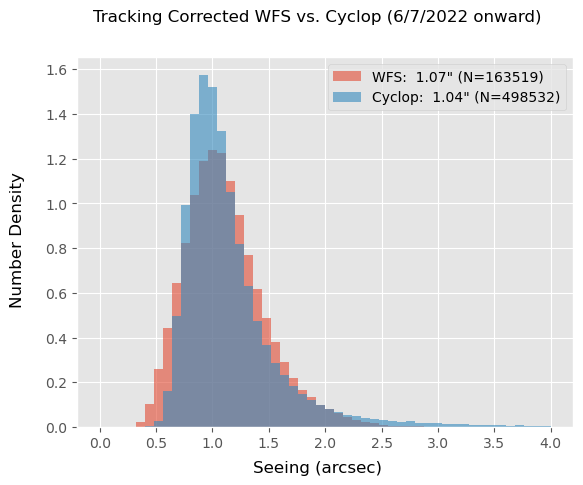

In [50]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    med_wfs = np.median(fixed_overlap['seeing_corr'])
    med_cyc = np.median(cyc['seeing'])
    w = ax.hist(fixed_overlap['seeing_corr'], density=True, bins=50, range=(0.0, 4.0), label=f"WFS: {med_wfs: .2f}\" (N={len(fixed_overlap)})", alpha=0.6)
    c = ax.hist(cyc['seeing'], density=True, bins=50, range=(0.0, 4.0), label=f"Cyclop: {med_cyc: .2f}\" (N={len(cyc)})", alpha=0.6)
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("Number Density")
    fig.suptitle("Tracking Corrected WFS vs. Cyclop (6/7/2022 onward)")
    ax.legend()
plt.savefig("wfs_corr_cyclop.pdf")
plt.savefig("wfs_corr_cyclop.png")
plt.show()